<a href="https://colab.research.google.com/github/maxilexow/ML20241/blob/main/ML_Ejercicio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador KNN


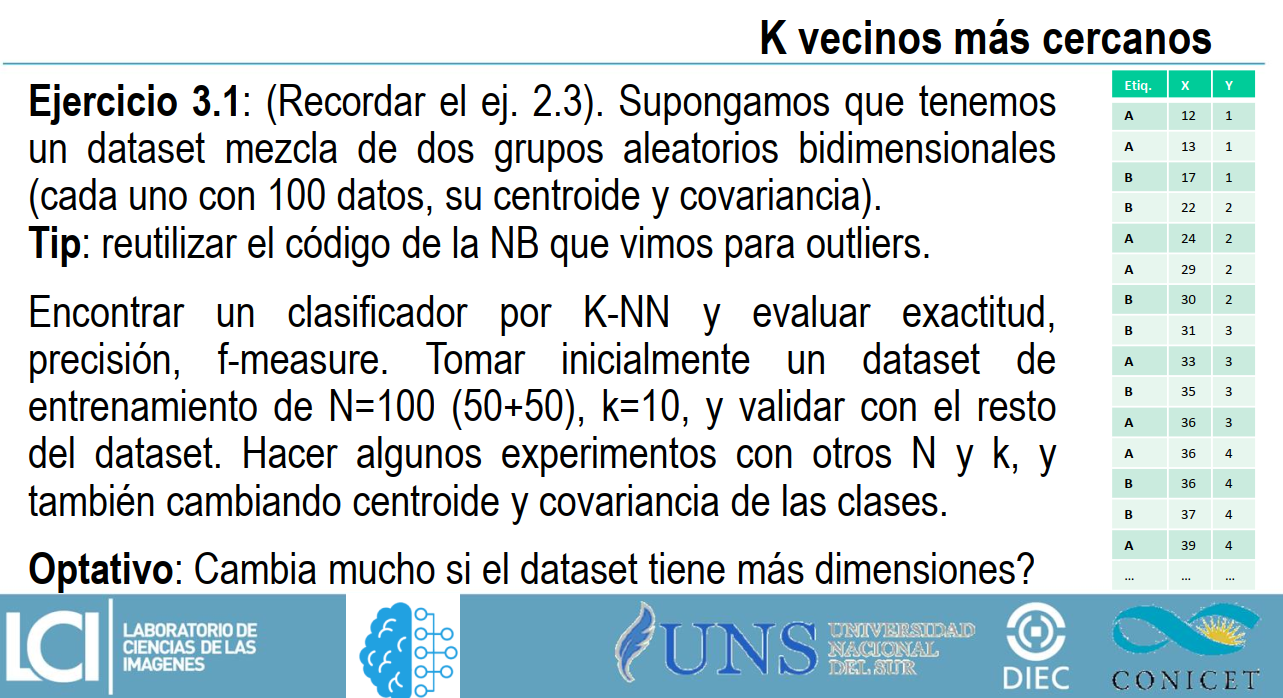

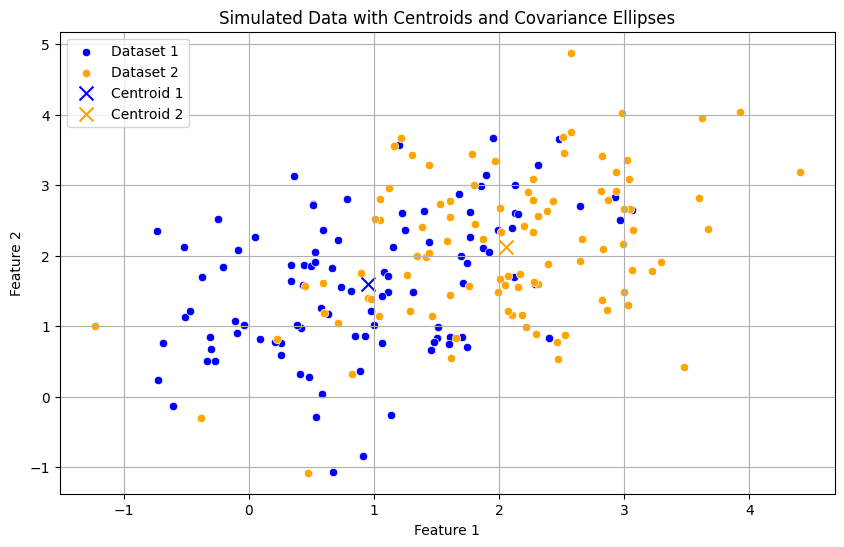

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define mean and covariance matrix
mean1 = [1, 1.5]
mean2 = [2, 2]
cov = [[1, 0.5], [0.5, 1]]

# Generate data for the first dataset
data1 = np.random.multivariate_normal(mean1, cov, 100)

# Generate data for the second dataset
data2 = np.random.multivariate_normal(mean2, cov, 100)

# Calculate centroids
centroid1 = np.mean(data1, axis=0)
centroid2 = np.mean(data2, axis=0)

# Plot the data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data1[:, 0], y=data1[:, 1], label='Dataset 1', color='blue')
sns.scatterplot(x=data2[:, 0], y=data2[:, 1], label='Dataset 2', color='orange')

# Plot centroids
plt.scatter(centroid1[0], centroid1[1], marker='x', color='blue', s=100, label='Centroid 1')
plt.scatter(centroid2[0], centroid2[1], marker='x', color='orange', s=100, label='Centroid 2')


# Set plot labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data with Centroids and Covariance Ellipses')
plt.legend()
plt.grid(True)
plt.show()


# El ritmo de la música
Este dataset está compuesto por canciones de 2017 con atributos de la API de Spotify. Cada canción ha sido etiquetada por alguien que usó "1", cuando le gusta la canción o "0" si no le gusta.

Su tarea es construir un clasificador que pueda predecir las preferencias de los atributos de la canción.

Cada fila del dataframe representa una canción. Hay 16 columnas, 13 de las cuales son atributos de la canción, una columna para el nombre de la canción, una para el artista y una columna llamada "destino", que es la etiqueta mencionada anteriormente para la canción. Los atributos de la pista son: acústica, bailabilidad, duración, energía, instrumentalidad, clave, vivacidad, volumen, modo, habla, tempo, marca de tiempo, valencia.

In [ ]:
import pandas as pd
#leemos el dataset
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")

# Elimino columnas con texto
columns_to_drop = ['song_title', 'artist', 'Unnamed: 0', 'time_signature']

# Drop the columns
df = df.drop(columns=columns_to_drop)

df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,target
0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,0.286,1
1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,0.588,1
2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,0.173,1
3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,0.230,1
4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,0.904,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,0.211,0
2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,0.867,0
2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,0.470,0
2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,0.623,0


Separo columnas con datos del target, y normalizo

In [ ]:
from sklearn.preprocessing import StandardScaler

target_column = 'target'

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled features back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

Calculo correlacion de columnas con mi target

In [ ]:
# Compute correlation of every column with the target column
correlation_with_target = X_scaled_df.corrwith(y)

# Display correlation matrix
print(correlation_with_target)

acousticness       -0.129627
danceability        0.176706
duration_ms         0.146749
energy              0.039688
instrumentalness    0.152594
key                 0.033594
liveness            0.026364
loudness           -0.072000
mode               -0.072336
speechiness         0.154006
tempo               0.034732
valence             0.107930
dtype: float64


Hago histogramas para comparar con target

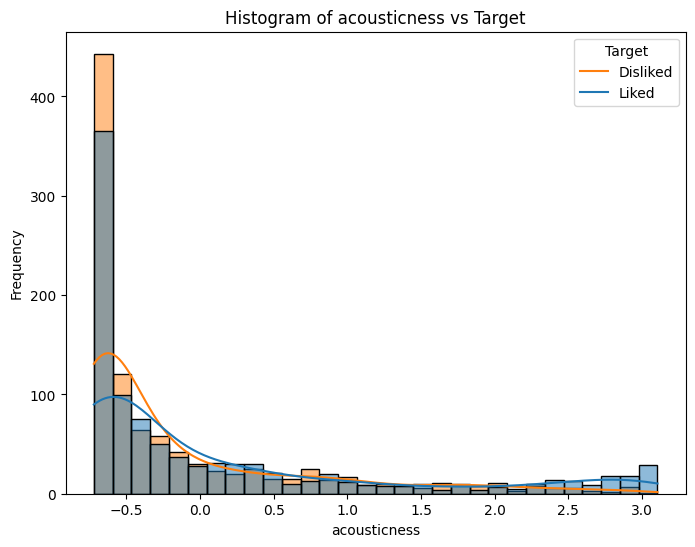

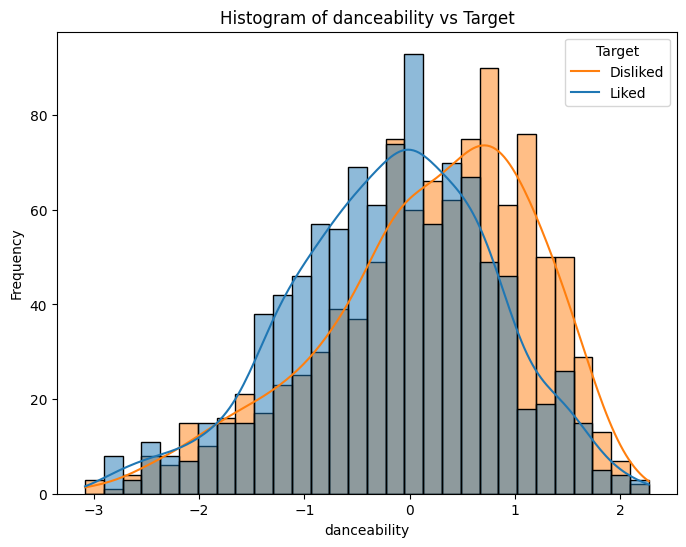

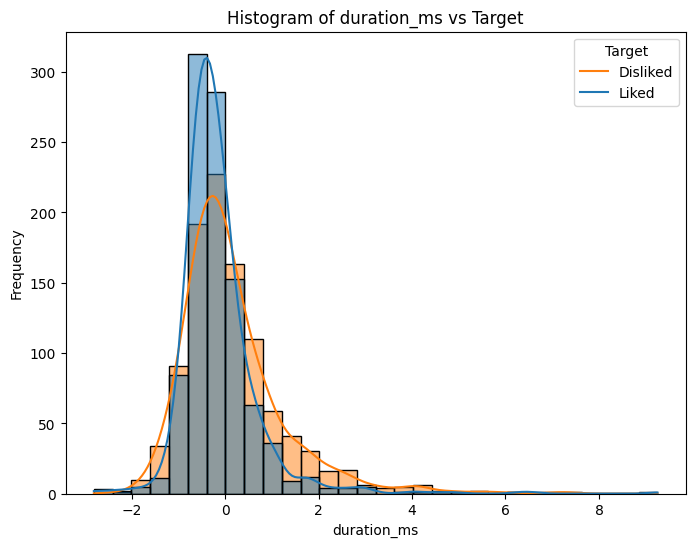

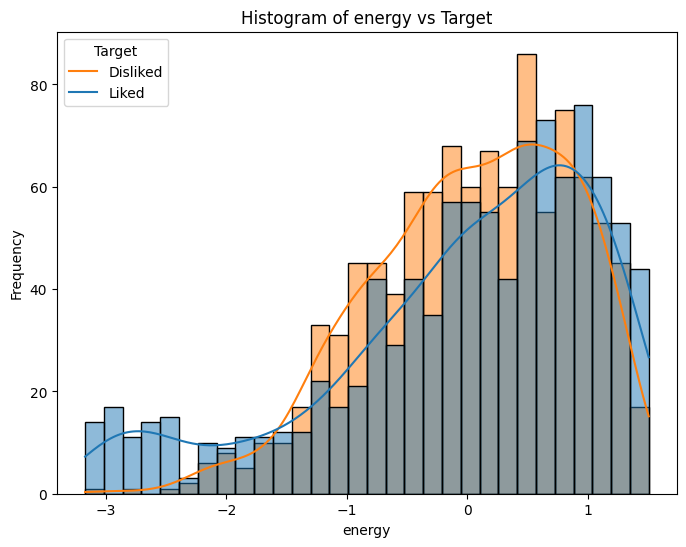

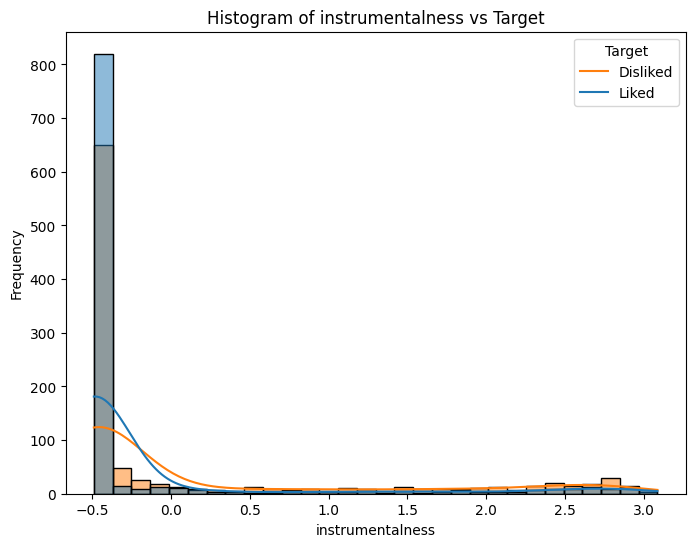

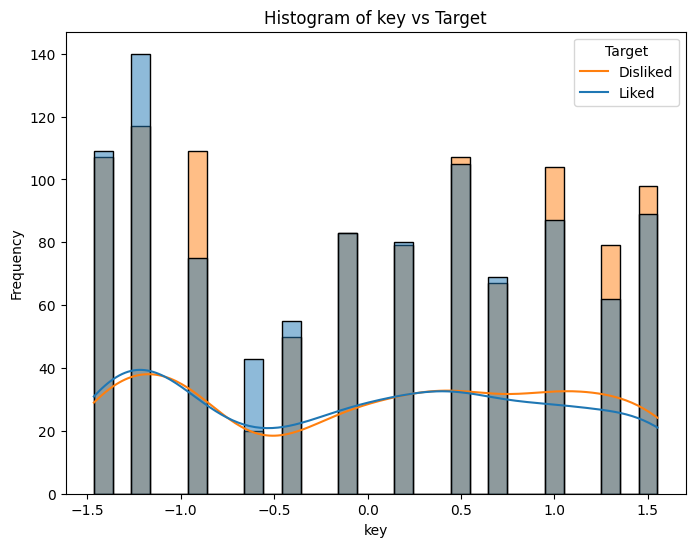

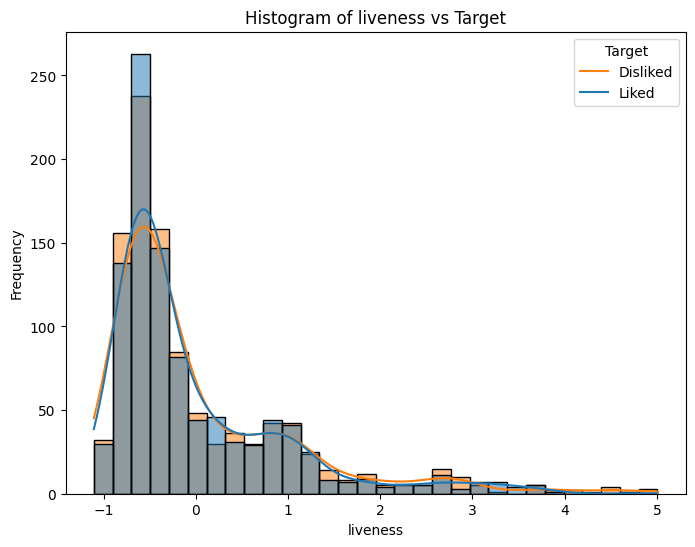

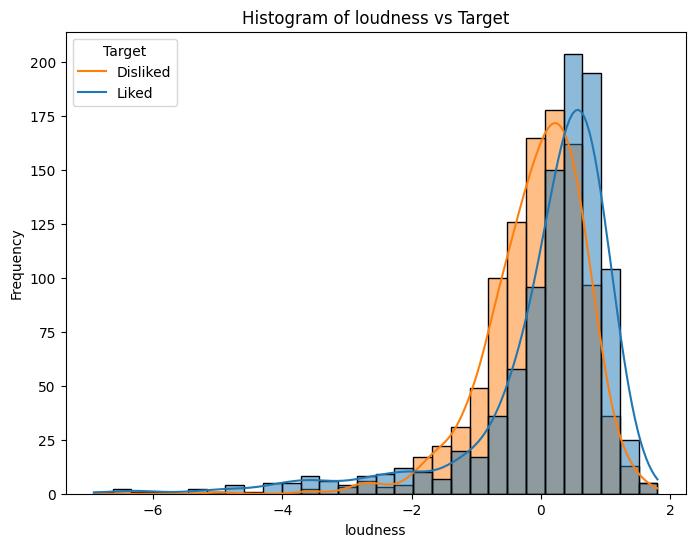

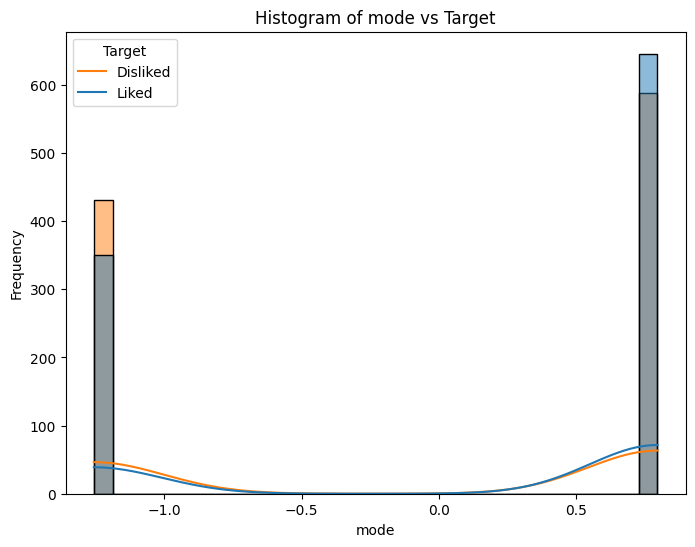

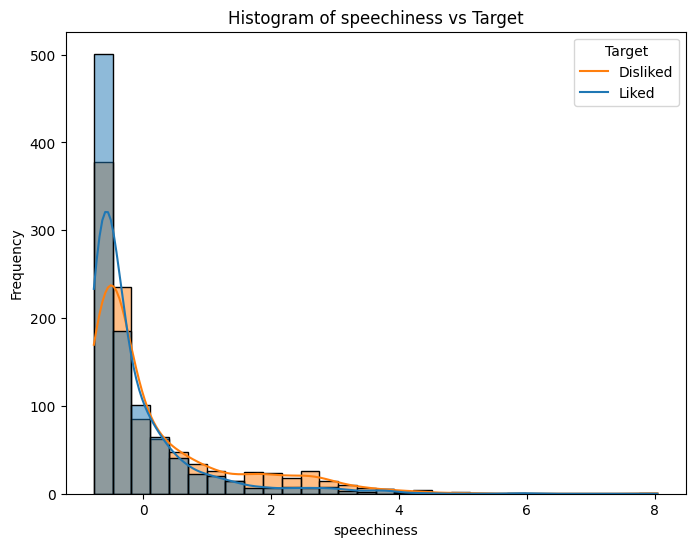

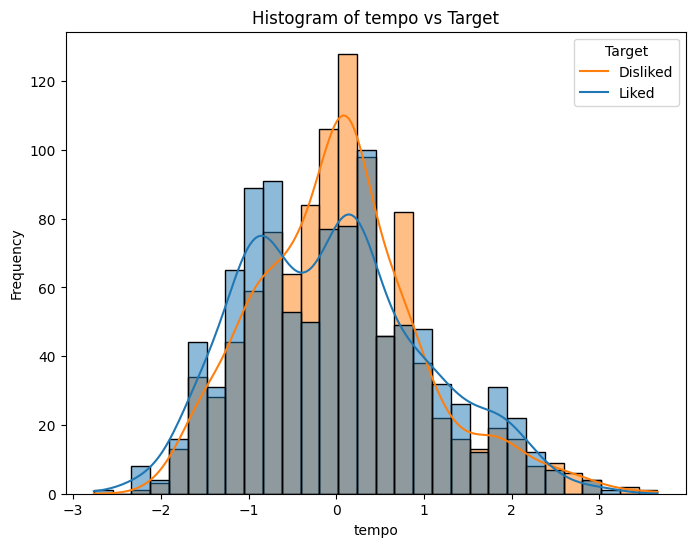

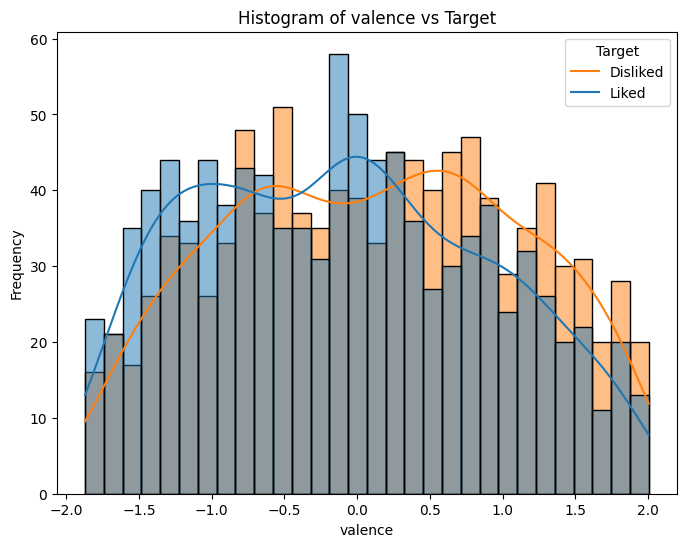

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through each column and create a histogram
for column in X_scaled_df.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=X_scaled_df, x=X_scaled_df[column], hue=y, bins=30, kde=True)
    plt.title(f'Histogram of {column} vs Target')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(title='Target', labels=['Disliked', 'Liked'])
    plt.show()


Hago cross-validation para dividir los datos en subsets

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming X_scaled_df contains selected features and y contains the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Initialize and train the logistic regression model
model = LogisticRegression()

model.fit(X_train, y_train)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X_scaled_df, y, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.64108911 0.59653465 0.52853598 0.64019851 0.59801489]
Mean Accuracy: 0.6008746284057687


1. Confusion matrix
2. Precision
3. Sensitivity
4. F1-score
5. ROC curve and AUC score
6. Precision-Recall Curve

Confusion Matrix:
[[134  72]
 [ 70 128]]
Precision: 0.64
Recall: 0.6464646464646465
F1-score: 0.6432160804020101


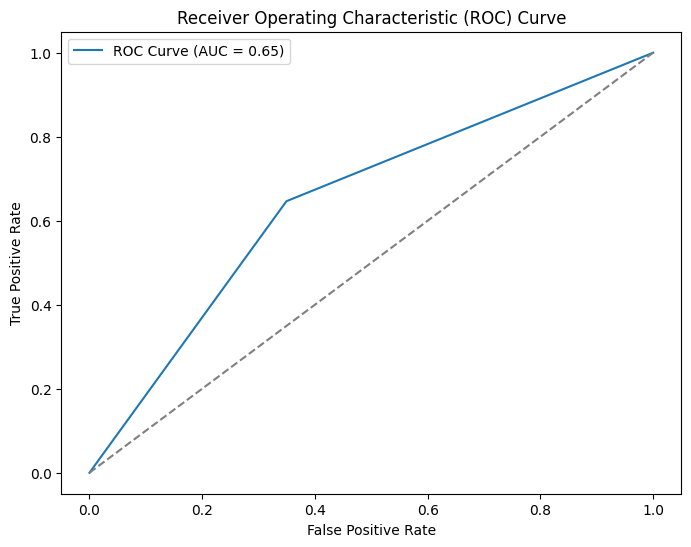

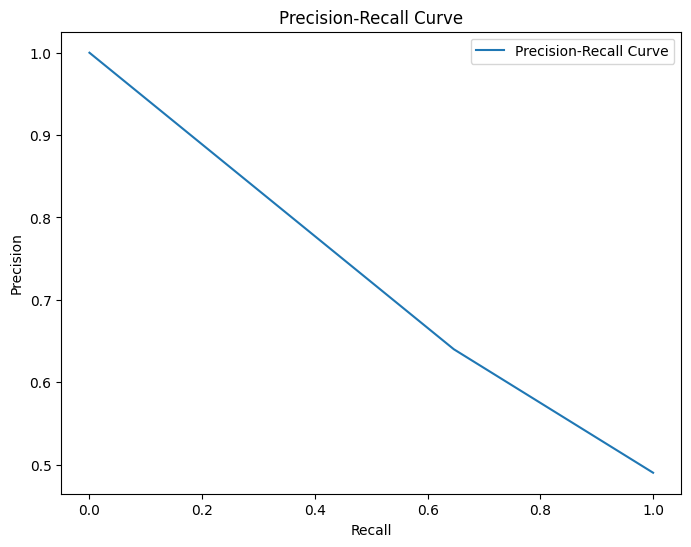

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Compute ROC-AUC score and plot ROC curve
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()